In [1]:
import pandas as pd
import io
import requests
from IPython.core.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
%matplotlib inline
%load_ext rpy2.ipython

pd.options.display.max_columns = 50

# Data Sources (references):
- country code list: https://pkgstore.datahub.io/JohnSnowLabs/country-and-continent-codes-list/country-and-continent-codes-list-csv_csv/data/b7876b7f496677669644f3d1069d3121/country-and-continent-codes-list-csv_csv.csv
    
- wealthy by country: https://en.wikipedia.org/wiki/List_of_countries_by_wealth_per_adult

- DALYs (anxiety-related) by country: https://ourworldindata.org/mental-health

# Data Import

In [6]:
dalys = pd.read_csv('../_data/anxiety-disorder-dalys-age-standardized-rate.csv')

dalys.head()

,Entity,Code,Year,DALYs (Disability-Adjusted Life Years) - Anxiety disorders - Sex: Both - Age: Age-standardized (Rate)
0,Afghanistan,AFG,1990,439.814752
1,Afghanistan,AFG,1991,439.658790
2,Afghanistan,AFG,1992,440.462746
3,Afghanistan,AFG,1993,440.429163
4,Afghanistan,AFG,1994,440.480624


In [7]:
dalys.isna().sum() / len(dalys)

Entity                                                                                                   0.000000
Code                                                                                                     0.151515
Year                                                                                                     0.000000
DALYs (Disability-Adjusted Life Years) - Anxiety disorders - Sex: Both - Age: Age-standardized (Rate)    0.000000
dtype: float64

Question: is poverty and anxiety correlated at the national level?

Type of problem: relationship (correlation)

Methods applicable: linear regression, correlation coefficient, ???

We need to get some data that measures wealth/poverty at the national level.

Taken from: https://en.wikipedia.org/wiki/List_of_countries_by_wealth_per_adult

In [8]:
wealth = pd.read_csv('../_data/median-wealth-per-adult-by-country-2019.csv')

In [9]:
wealth.head()

,Country,Median wealth per adult (US dollars),Mean wealth per adult (US dollars),Adult population (thousands)
0,Afghanistan,640,1463,"16,838"
1,Albania,"14,731","31,366","2,225"
2,Algeria,"3,267","9,348","26,983"
3,Angola,"1,370","3,649","13,403"
4,Antigua and Barbuda,"6,961","24,964",71


In [10]:
wealth.isna().sum() / len(wealth)

Country                                 0.0
Median wealth per adult (US dollars)    0.0
Mean wealth per adult (US dollars)      0.0
Adult population (thousands)            0.0
dtype: float64

In [11]:
df = pd.merge(left=dalys, right=wealth, how='inner', left_on='Entity', right_on='Country')

In [12]:
df = df.rename(columns={
    'DALYs (Disability-Adjusted Life Years) - Anxiety disorders - Sex: Both - Age: Age-standardized (Rate)':'DALYs',
})

In [13]:
df.shape

(4592, 8)

In [14]:
df.isna().sum() / len(df) * 100

Entity                                  0.0
Code                                    0.0
Year                                    0.0
DALYs                                   0.0
Country                                 0.0
Median wealth per adult (US dollars)    0.0
Mean wealth per adult (US dollars)      0.0
Adult population (thousands)            0.0
dtype: float64

In [15]:
# df[['Entity','Year']].groupby('Year').count().plot.bar();

In [16]:
x_label = 'Median wealth per adult (US dollars)'
y_label = 'DALYs'

In [17]:
df[x_label] = df[x_label].apply(lambda x: float(str(x).replace(',','')))

In [18]:
df['Year'].max()

2017

Look at relationship for 2017...

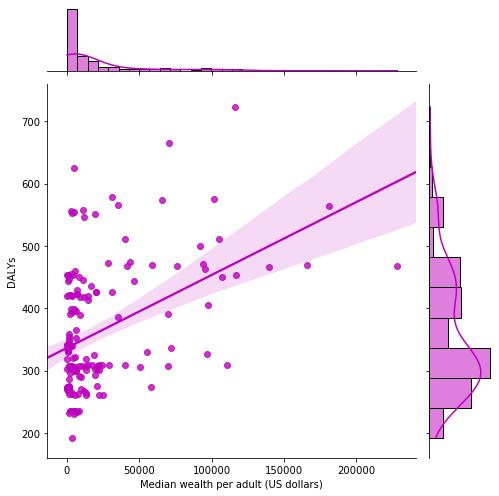

In [19]:
dft = df[df['Year'] == df['Year'].max()]
g = sns.jointplot(data=dft, x=x_label, y=y_label, kind="reg", truncate=False, color="m", height=7)

Seems to be a possible correlation, but the data in the x and y axes are not normally distributed (especially the x-axis, median wealth, which is highly skewed to the right). So i'm not sure that a linear regression is really a valid model here. 

What if we split this up by continent? Does the distribution (of residuals) become more normal?

In [20]:
# for CSV
url_data = "https://pkgstore.datahub.io/JohnSnowLabs/country-and-continent-codes-list/country-and-continent-codes-list-csv_csv/data/b7876b7f496677669644f3d1069d3121/country-and-continent-codes-list-csv_csv.csv"
r = requests.get(url_data).content
country = pd.read_csv(io.StringIO(r.decode('utf-8')))
country.head()

,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number
0,Asia,AS,"Afghanistan, Islamic Republic of",AF,AFG,4.0
1,Europe,EU,"Albania, Republic of",AL,ALB,8.0
2,Antarctica,AN,Antarctica (the territory South of 60 deg S),AQ,ATA,10.0
3,Africa,AF,"Algeria, People's Democratic Republic of",DZ,DZA,12.0
4,Oceania,OC,American Samoa,AS,ASM,16.0


In [21]:
country = country[['Continent_Name','Three_Letter_Country_Code']]

In [22]:
df = df.merge(country, how='left', left_on='Code', right_on='Three_Letter_Country_Code')

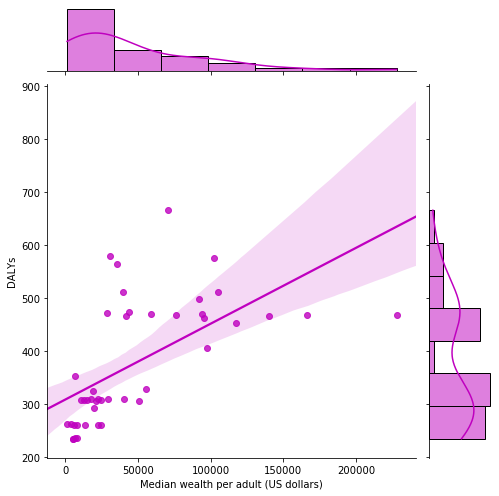

In [23]:
# look at relationship between dependent and independent variable for Europe, 2017
dft = df[(df['Year'] == df['Year'].max()) & (df['Continent_Name']=='Europe')]
g = sns.jointplot(data=dft, x=x_label, y=y_label, kind="reg", truncate=False, color="m", height=7)

Interesting. one outlier is skeweing the regression line - I wonder if we change the cost function can we get a more general fit that is robust to outliers?

Let's try to fit this regression using R:

In [75]:
df_r = dft[[x_label,y_label]]
df_r.shape

In [81]:
%%R -i df_r,x_label,y_label
# summary(lm(y_label ~ x_label, data = df))
lm(y_label ~ x_label, data = df_r)

R[write to console]: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]) : 
  contrasts can be applied only to factors with 2 or more levels

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In storage.mode(v) <- "double" :
R[write to console]:  NAs introduced by coercion




Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]) : 
  contrasts can be applied only to factors with 2 or more levels


Bah can't get it to work. What about with some made up data?

In [80]:
%%R
X=c(1,4,5,7)
Y = c(2,4,3,9)
summary(lm(Y~X))


Call:
lm(formula = Y ~ X)

Residuals:
    1     2     3     4 
 0.88 -0.24 -2.28  1.64 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   0.0800     2.3000   0.035    0.975
X             1.0400     0.4822   2.157    0.164

Residual standard error: 2.088 on 2 degrees of freedom
Multiple R-squared:  0.6993,	Adjusted R-squared:  0.549 
F-statistic: 4.651 on 1 and 2 DF,  p-value: 0.1638



Dunno why it's not working in R. Let's go back to Python.

In [82]:
# scipy
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

In [83]:
import statsmodels.api as sm

In [84]:
# statsmodels
# spector_data.exog = sm.add_constant(spector_data.exog, prepend=False)

# Fit and summarize OLS model
mod = sm.OLS(dft[y_label], dft[x_label])

res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  DALYs   R-squared (uncentered):                   0.637
Model:                            OLS   Adj. R-squared (uncentered):              0.628
Method:                 Least Squares   F-statistic:                              75.32
Date:                Tue, 20 Oct 2020   Prob (F-statistic):                    5.30e-11
Time:                        19:22:40   Log-Likelihood:                         -303.18
No. Observations:                  44   AIC:                                      608.4
Df Residuals:                      43   BIC:                                      610.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------

Assumptions Made in Linear-Regression Models

(1) For any given value of x, the corresponding value of y has an average value α + βx, which is a linear function of x.

(2) For any given value of x, the corresponding value of y is normally distrib- uted about α + βx with the same variance σ2 for any x.

(3) For any two data points (x1, y1), (x2, y2), the error terms e1, e2 are independent of each other.